# Phase Information
### This notebook runs through an example of how to obtain phase information from two signals which will be useful for velocity estimation and clutter mitigation.
### Note: When applying to real signals obtained by the radar, it may be necessary to isolate each of the suspected targets within some small frequency band and calculate the phase difference separately for each. I am not sure how this would handle phase differences between multiple real targets as well as clutter at the same time.
***

In [2]:
# Imports
from scipy import signal
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

# Styling
from matplotlib import style
style.use('seaborn-dark')


## Signal Setup
$ \begin{align}
    A(t) &= \sin{\left( \omega t + \phi_0 \right)}
    & \\
    f &= 5\text{MHz} \\
    \omega &= 2\pi(5\text{MHz}) \\
    \phi_0 &= \left[ 0 \text{, } \pi / 3 \right] \\
\end {align} $

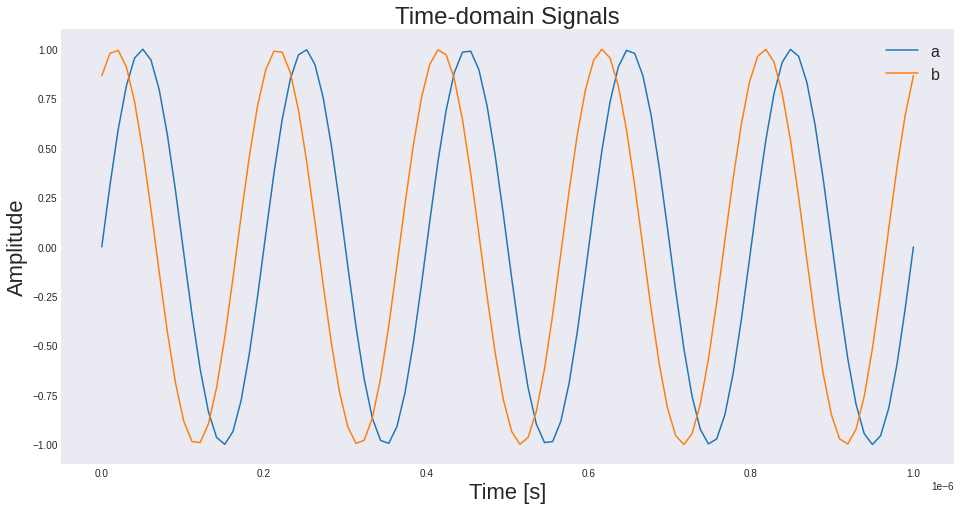

In [3]:
# Signal
num_points = 100
time = np.linspace(0, 1e-6, num_points)

f = 2 * pi * 5e6
phase_offset = pi / 3

a = np.sin(f * time)
b = np.sin(f * time + phase_offset)

# Plotting
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(8)
ax.set_title('Time-domain Signals', fontsize=24)
ax.set_xlabel('Time [s]', fontsize=22)
ax.set_ylabel('Amplitude', fontsize=22)

ax.plot(time, a, label='a')
ax.plot(time, b, label='b')

ax.legend(loc='upper right', fontsize=16)

## Calculate cross-correlation between the two signals
$ \begin {align}
    z[k] &= (x * y)(k - N + 1) = \sum_{l=0}^{||x||-1}x_l y_{l-k+N-1}^{*}
\end {align} $
for $k=0, 1, \ldots, ||x||+||y|| - 2$, where $||x||$, $||y||$ are the lengths of $x$ and $y$, respectively and $N=\text{max}\left( ||x||, ||y|| \right)$.
### The peak of the cross-correlation gives the time shift between the two signals. This can then be used to calculate the phase shift in terms of $-\pi \rightarrow \pi$.

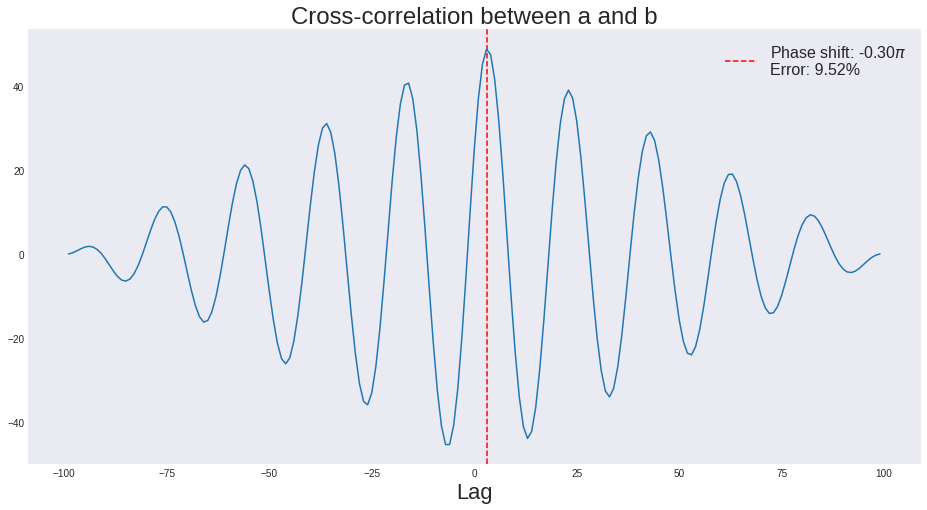

In [27]:
# Calculate cross-correlation, obtain lags for x-axis, and time expanded by convolution
corr = signal.correlate(a, b, mode='full')
lags = signal.correlation_lags(a.size, b.size, mode='full')
dt = np.linspace(-time[-1], time[-1], 2 * num_points - 1)

# Plotting setup
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(8)
ax.set_title('Cross-correlation between a and b', fontsize=24)
ax.set_xlabel('Lag', fontsize=22)

# Obtain max value of correlation function
max_corr = corr.argmax()
lag_max = lags[max_corr]

# Time shift amount is where the max correlation occurs
recovered_time_shift = dt[max_corr]
recovered_phase_shift = 2 * pi * (((0.5 + recovered_time_shift * f) % 1.0) - 0.5)

# Calculate error from original phase shift
error = abs(abs(phase_offset) - abs(pi * recovered_phase_shift)) / phase_offset

ax.axvline(lag_max, c='r', linestyle='dashed', label='Phase shift: %0.2f$\pi$\nError: %0.2f%%' % 
    (recovered_phase_shift, error * 100))
ax.legend(loc='upper right', fontsize=16)

ax.plot(lags, corr, label='a')